In [410]:
!pip install imbalanced-learn


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [411]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

sns.set(rc = {'figure.figsize':(15,8)}, style='white')

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)


In [412]:
train_url='./fraudTrain.csv'
test_url='./fraudTest.csv'

train_df=pd.read_csv(train_url, low_memory=False, index_col=0) #ignore sequencer
test_df=pd.read_csv(test_url, low_memory=False, index_col=0) #ignore sequencer

In [413]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop               

In [414]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-null  i

**Data Dictionary:**

| No. | Field                  | Description                          |
|-----|------------------------|--------------------------------------|
| 1   | trans_date_trans_time  | Transaction time stamp               |
| 2   | cc_num                 | Credit card number                   |
| 3   | merchant               | Merchant name                        |
| 4   | category               | Transaction category                 |
| 5   | amt                    | Transaction amount                   |
| 6   | first                  | First name of card holder            |
| 7   | last                   | Last name of card holder             |
| 8   | gender                 | Sex of card holder                   |
| 9   | street                 | Transaction address                  |
| 10  | city                   | Transaction city                     |
| 11  | state                  | Transaction state                    |
| 12  | zip                    | Transaction zipcode                  |
| 13  | lat                    | Transaction latitude                 |
| 14  | long                   | Transaction longitude                |
| 15  | city_pop               | Population of the city               |
| 16  | job                    | Job of the card holder               |
| 17  | dob                    | Date of birth of card holder         |
| 18  | trans_num              | Transaction number                   |
| 19  | unix_time              | Time in unix format                  |
| 20  | merch_lat              | Latitude of the merchant             |
| 21  | merch_long             | Longitude of the merchant            |
| 22  | is_fraud               | Nature of transaction (fraud or not fraud) |



In [415]:
labels=["Genuine", "Fraud"]

fraud_or_not = train_df["is_fraud"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=train_df['is_fraud'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue", "black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

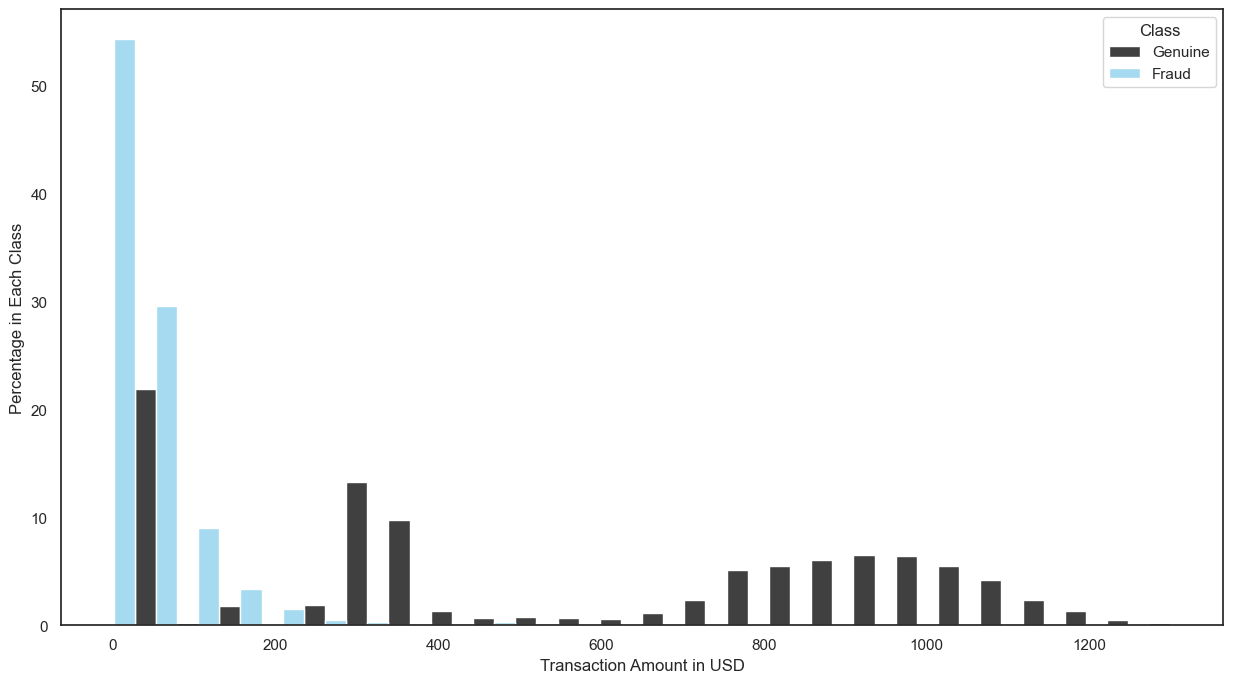

In [416]:
#amount vs fraud
data_subset = train_df[train_df['amt'] <= 1300]
palette = {0: 'skyblue', 1: 'black'}
ax = sns.histplot(data=data_subset, x='amt', hue='is_fraud', stat='percent', multiple='dodge', common_norm=False, bins=25, palette=palette)
ax.set_ylabel('Percentage in Each Class')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Class', labels=['Genuine', 'Fraud'])
plt.show()

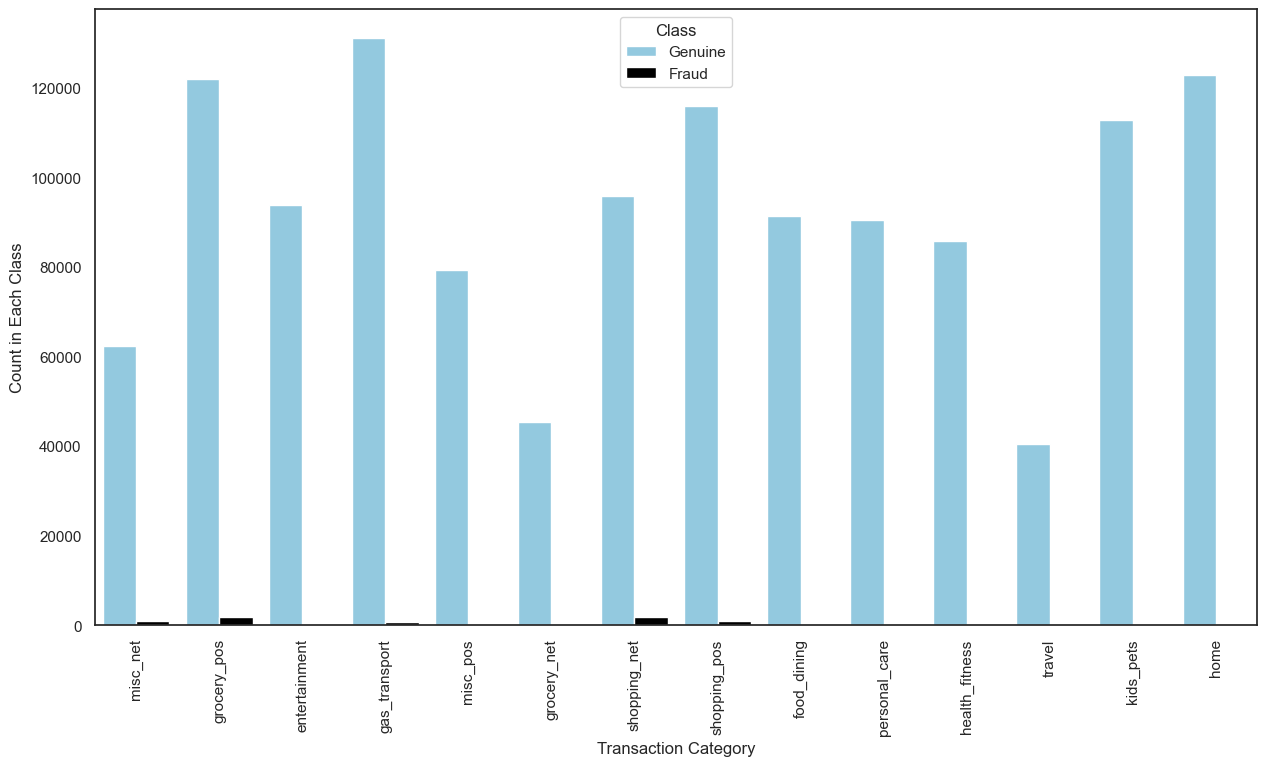

In [417]:
palette = {0: 'skyblue', 1: 'black'}
ax = sns.countplot(x='category', hue='is_fraud', data=train_df, palette=palette)
plt.xticks(rotation=90)
ax.set_ylabel('Count in Each Class')
ax.set_xlabel('Transaction Category')
plt.legend(title='Class', labels=['Genuine', 'Fraud'])
plt.show()

In [418]:
#constructing the merchant-transaction count distribution
df_merchant = train_df[['merchant','trans_num']].groupby(['merchant']).count().reset_index()
df_merchant.columns = ['merchant', 'merchant_count']

#creating the zip-fraud distribution
df_fraud_merchant = train_df[['merchant', 'is_fraud', 'trans_num']].groupby(['merchant', 'is_fraud']).count().reset_index()
df_fraud_merchant.columns = ['merchant', 'is_fraud', 'Transaction count']
print(df_fraud_merchant)

df_fraud_merchant = df_fraud_merchant.merge(df_merchant[['merchant', 'merchant_count']], how='inner', on='merchant')

df_fraud_merchant['Transaction percentage'] = (df_fraud_merchant['Transaction count']/df_fraud_merchant['merchant_count'])*100

#Display the top 20 merchant with high fraudulent transaction volumes
df_fraud_merchant[df_fraud_merchant['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

                          merchant  is_fraud  Transaction count
0              fraud_Abbott-Rogahn         0               1841
1              fraud_Abbott-Rogahn         1                  3
2             fraud_Abbott-Steuber         0               1757
3             fraud_Abbott-Steuber         1                  6
4         fraud_Abernathy and Sons         0               1747
...                            ...       ...                ...
1367          fraud_Ziemann-Waters         1                  6
1368  fraud_Zieme, Bode and Dooley         0               2552
1369  fraud_Zieme, Bode and Dooley         1                  8
1370              fraud_Zulauf LLC         0               1781
1371              fraud_Zulauf LLC         1                  2

[1372 rows x 3 columns]


,merchant,is_fraud,Transaction count,merchant_count,Transaction percentage
672,fraud_Kozey-Boehm,1,48,1866,2.572347
489,"fraud_Herman, Treutel and Dickens",1,33,1300,2.538462
606,fraud_Kerluke-Abshire,1,41,1838,2.230686
159,fraud_Brown PLC,1,26,1176,2.210884
400,fraud_Goyette Inc,1,42,1943,2.161606
1220,fraud_Terry-Huel,1,43,1996,2.154309
562,fraud_Jast Ltd,1,42,1953,2.150538
1100,"fraud_Schmeler, Bashirian and Price",1,41,1968,2.083333
145,fraud_Boyer-Reichert,1,38,1908,1.991614
742,"fraud_Langworth, Boehm and Gulgowski",1,39,1969,1.980701


In [419]:
import pandas as pd
import datetime

# convert dob into age
now = datetime.datetime.now()
train_df['dob'] = pd.to_datetime(train_df['dob'], format='%Y-%m-%d')
train_df['age'] = (now.date().year - train_df['dob'].dt.year)

# combine first and last names
train_df['full_name'] = train_df['first'] + " " + train_df['last']

In [420]:
import sweetviz as sv
my_report = sv.analyze(
    train_df,
    target_feat='is_fraud'
)
my_report.show_html()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [421]:
train_df.head(n=5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,full_name
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,36,Jennifer Banks
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,46,Stephanie Gill
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,62,Edward Sanchez
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,57,Jeremy White
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,38,Tyler Garcia


In [422]:
X = train_df.drop(['is_fraud'], axis=1)
y = train_df['is_fraud']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=4
)

### Check datatype of 'suspicious' column

In [423]:
def date_to_timestamp(date):
    return pd.Timestamp(date).timestamp()

X_train['trans_date_trans_timestamp'] = X_train['trans_date_trans_time'].apply(date_to_timestamp)

X_train['trans_date_trans_time'] = X_train['trans_date_trans_timestamp']

X_train = X_train.drop(['trans_date_trans_timestamp'], axis=1)

X_train = X_train.rename(columns={
    "trans_num": "trans_id"
})

X_train.head(n=100)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_id,unix_time,merch_lat,merch_long,age,full_name
419112,1.562533e+09,38588538868506,fraud_Abernathy and Sons,food_dining,22.42,Jacqueline,Curry,F,3047 Jeff Place,Marathon,TX,79842,30.1886,-103.2214,498,Lexicographer,1990-11-23,4609d39437b5433fece4a3621aeb722d,1341694120,29.803451,-102.470456,34,Jacqueline Curry
693405,1.571773e+09,213112402583773,fraud_Schumm PLC,health_fitness,1.39,Ana,Howell,F,4664 Sanchez Common Suite 930,Bradley,SC,29819,34.0326,-82.2027,1523,Research scientist (physical sciences),1984-06-03,f516020b74184d502d0992e6da8dcd5c,1350934530,34.599072,-82.056040,40,Ana Howell
1271246,1.591944e+09,4586810168620942,"fraud_Ferry, Reichel and DuBuque",grocery_net,14.04,Michelle,Gregory,F,6983 Carrillo Isle,Edisto Island,SC,29438,32.5486,-80.3070,2408,"Sales professional, IT",1997-07-05,1ed6ed0e7b10198994356dc3f5ebfbf7,1371019669,32.499761,-79.593420,27,Michelle Gregory
333183,1.559936e+09,6535328428560433,fraud_Altenwerth-Kilback,home,20.87,Michelle,Beck,F,2887 Olson Road Suite 439,Minneapolis,MN,55428,45.0632,-93.3811,1022298,Analytical chemist,1967-10-28,f1836ba87430d0c5373fe23bf8e9996d,1339097419,44.373684,-94.036093,57,Michelle Beck
1063308,1.584422e+09,4900628639996,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,69.59,Michael,Johnson,M,094 Owens Underpass,Norwalk,CA,90650,33.9056,-118.0818,105549,Firefighter,1973-09-22,ec1715b32bb60c5a6fff347d9dcc810e,1363497081,34.446528,-118.164904,51,Michael Johnson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221517,1.590424e+09,4890424426862856940,"fraud_Lowe, Dietrich and Erdman",kids_pets,15.79,Jeremy,Whitney,M,0371 Aimee Neck Suite 856,Sacramento,CA,95827,38.5662,-121.3286,757530,Magazine features editor,1979-04-30,be0f668177a7f26eb60c6a3eb8c86968,1369498789,37.990781,-120.730593,45,Jeremy Whitney
763773,1.574515e+09,4210078554961359092,fraud_Zboncak Ltd,food_dining,2.98,Valerie,Clark,F,7402 West Ranch,Lowell,OR,97452,43.9210,-122.7806,1420,Systems analyst,1965-11-11,28faf72414184bc8c30651a22e87c68d,1353676387,43.246303,-123.406798,59,Valerie Clark
919218,1.577718e+09,4988304376504,fraud_Kling-Ernser,entertainment,1.33,William,Thompson,M,977 Rita Grove Apt. 000,Rock Tavern,NY,12575,41.4575,-74.1659,2258,Building surveyor,1937-03-17,2bb02d837a95e9605072c80ce3e555c6,1356879135,41.453861,-74.468539,87,William Thompson
10969,1.546872e+09,4342532437704183,fraud_Medhurst Inc,home,53.12,Kevin,Elliott,M,1852 Vincent Isle Suite 328,Newark Valley,NY,13811,42.2281,-76.1625,4354,Further education lecturer,1994-02-16,679712822b5d96b3ecaf5398093ed688,1325947504,42.391799,-76.197079,30,Kevin Elliott


In [424]:
duplicate_num_row = X_train.duplicated().sum()
print(f"There are {duplicate_num_row} duplicate row(s) in this DataFrame.")

There are 0 duplicate row(s) in this DataFrame.


In [425]:
# Check which column has missing values
missing_val_num = X_train.isnull().sum()
print(f"There are {missing_val_num} missing values.")

There are trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_id                 0
unix_time                0
merch_lat                0
merch_long               0
age                      0
full_name                0
dtype: int64 missing values.


In [426]:
X_train['trans_id'].value_counts()

trans_id
4609d39437b5433fece4a3621aeb722d    1
b143fe36c60c08fdf753a0412347c4fa    1
0055d9f86721d23a0517c82f5dfca303    1
a893429f2c4e547c3c384c61f5e67779    1
cbb3b75c01debf847228ad194007a797    1
                                   ..
9d8178c74deb6e4e7905c63126d1580b    1
b118d6ca95790dec8e1bd62453b85661    1
d791021421979fc770aa63ce61d42f11    1
b573b543d97a44c869d993a623d75f9d    1
83fc3895b5caa19f322884083dfc3cc7    1
Name: count, Length: 1037340, dtype: int64

In [427]:
columns_dropped = [
    "trans_date_trans_time",
    "first", 
    "last", 
    "cc_num",
    "gender", 
    "street", 
    "city",
    "state", 
    "zip", 
    "lat",
    "long",
    "merch_lat", 
    "merch_long", 
    "city_pop",
    "dob",
    "unix_time",
    "full_name"
]

columns_check = [
    "merchant", 
    "category", 
    "job"
]

columns_kept = [
    "merchant", 
    "category", 
    "amt", 
    "job", 
    "age",
]

In [428]:
X_train = X_train.drop(columns_dropped, axis=1)



In [429]:
X_train.head(n=10)

,merchant,category,amt,job,trans_id,age
419112,fraud_Abernathy and Sons,food_dining,22.42,Lexicographer,4609d39437b5433fece4a3621aeb722d,34
693405,fraud_Schumm PLC,health_fitness,1.39,Research scientist (physical sciences),f516020b74184d502d0992e6da8dcd5c,40
1271246,"fraud_Ferry, Reichel and DuBuque",grocery_net,14.04,"Sales professional, IT",1ed6ed0e7b10198994356dc3f5ebfbf7,27
333183,fraud_Altenwerth-Kilback,home,20.87,Analytical chemist,f1836ba87430d0c5373fe23bf8e9996d,57
1063308,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,69.59,Firefighter,ec1715b32bb60c5a6fff347d9dcc810e,51
686327,fraud_Kozey-Boehm,shopping_net,80.29,"Development worker, community",23d8157339e40a8ee10000d42cf6a184,35
1267750,fraud_Connelly-Carter,home,44.78,Diagnostic radiographer,bf8682a0df8342a222eec29c1c82ecb5,56
955001,fraud_Reichel LLC,personal_care,35.21,Chief Executive Officer,6271f547eb5730ecb0100568a60647c9,46
1248511,fraud_Kassulke Inc,entertainment,264.38,Clothing/textile technologist,51ea4645e0a96d8bdaaba4b0eb99b13c,45
933042,"fraud_Monahan, Bogisich and Ledner",misc_pos,52.74,Neurosurgeon,59f25514ce6d14133de7afcedc7792be,52


In [430]:
X_train = X_train.drop(["trans_id"], axis=1)

In [431]:
X_train.head(n=20)


,merchant,category,amt,job,age
419112,fraud_Abernathy and Sons,food_dining,22.42,Lexicographer,34
693405,fraud_Schumm PLC,health_fitness,1.39,Research scientist (physical sciences),40
1271246,"fraud_Ferry, Reichel and DuBuque",grocery_net,14.04,"Sales professional, IT",27
333183,fraud_Altenwerth-Kilback,home,20.87,Analytical chemist,57
1063308,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,69.59,Firefighter,51
686327,fraud_Kozey-Boehm,shopping_net,80.29,"Development worker, community",35
1267750,fraud_Connelly-Carter,home,44.78,Diagnostic radiographer,56
955001,fraud_Reichel LLC,personal_care,35.21,Chief Executive Officer,46
1248511,fraud_Kassulke Inc,entertainment,264.38,Clothing/textile technologist,45
933042,"fraud_Monahan, Bogisich and Ledner",misc_pos,52.74,Neurosurgeon,52


In [432]:
# put age into different categories
age_bins = [0, 35, 65, float('inf')]
age_labels = ['intermediate', 'top', 'retired']
X_train['age_categories'] = pd.cut(X_train['age'], bins=age_bins, labels=age_labels, right=False)

In [433]:
X_train = X_train.drop(['age'], axis=1)
X_train

,merchant,category,amt,job,age_categories
419112,fraud_Abernathy and Sons,food_dining,22.42,Lexicographer,intermediate
693405,fraud_Schumm PLC,health_fitness,1.39,Research scientist (physical sciences),top
1271246,"fraud_Ferry, Reichel and DuBuque",grocery_net,14.04,"Sales professional, IT",intermediate
333183,fraud_Altenwerth-Kilback,home,20.87,Analytical chemist,top
1063308,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,69.59,Firefighter,top
...,...,...,...,...,...
639432,"fraud_Greenfelder, Bartoletti and Davis",misc_net,4.04,Chief Strategy Officer,top
653672,fraud_Bogisich-Weimann,kids_pets,131.78,Podiatrist,top
120705,fraud_Kutch LLC,gas_transport,38.17,Press sub,top
991406,fraud_Harber Inc,gas_transport,86.70,Chief Strategy Officer,top


In [434]:
# check data type
for i in X_train:
    if X_train[i].dtypes == "object":
        X_train[i].astype('category')

for i in X_train:
    print(X_train[i].dtype)

object
object
float64
object
category


### Normalizing 'amt' feature using StandardScaler

In [435]:
# normalize 'amt'
from sklearn.preprocessing import StandardScaler
amt_scaler = StandardScaler()
amt_scaler = amt_scaler.fit(X_train[['amt']])

X_train['normalized_amt'] = amt_scaler.transform(X_train[['amt']])
X_train = X_train.drop(['amt'], axis=1)


### One-Hot-Encoding of categorical features

In [439]:
from sklearn.preprocessing import OneHotEncoder

merch_enc = OneHotEncoder(handle_unknown="ignore")
merch_enc = merch_enc.fit(X_train[['merchant']])
_ohe_array = merch_enc.transform(X_train[['merchant']])

_ohe_names = merch_enc.get_feature_names_out()

for i in range(_ohe_array.shape[1]):
  col_data = _ohe_array[:, i]
  X_train[_ohe_names[i]] = col_data.toarray().ravel()
X_train = X_train.drop(['merchant'], axis=1)


catego_enc = OneHotEncoder(handle_unknown='ignore')
catego_enc = catego_enc.fit(X_train[['category']])
_ohe_array = catego_enc.transform(X_train[['category']])

_ohe_names = catego_enc.get_feature_names_out()
for i in range(_ohe_array.shape[1]):
  X_train[_ohe_names[i]] = _ohe_array[:,i].toarray().ravel()
X_train = X_train.drop(['category'], axis=1)


job_enc = OneHotEncoder(handle_unknown='ignore')
job_enc = job_enc.fit(X_train[['job']])
_ohe_array = job_enc.transform(X_train[['job']])

_ohe_names = job_enc.get_feature_names_out()
for i in range(_ohe_array.shape[1]):
  X_train[_ohe_names[i]] = _ohe_array[:,i].toarray().ravel()
X_train = X_train.drop(['job'], axis=1)

age_enc = OneHotEncoder(handle_unknown='ignore')
age_enc = age_enc.fit(X_train[['age_categories']])
_ohe_array = age_enc.transform(X_train[['age_categories']])

_ohe_names = age_enc.get_feature_names_out()
for i in range(_ohe_array.shape[1]):
  X_train[_ohe_names[i]] = _ohe_array[:,i].toarray().ravel()
X_train = X_train.drop(['age_categories'], axis=1)

X_train

KeyError: "None of [Index(['merchant'], dtype='object')] are in the [columns]"

### Oversampling using SMOTE

In [437]:
from imblearn.over_sampling import SMOTE, ADASYN

X_smote, Y_smote = SMOTE().fit_resample(X_train, y_train)

In [441]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators = 10, random_state = 42)
model_RF.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)